In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

import warnings

import sklearn
import sklearn.ensemble
import sklearn.inspection
from sklearn.model_selection import train_test_split

from datetime import datetime, timedelta

Part 1: Data Understanding and Preparation
==

**Note:** The first part of section, r.e. understanding, is largely a recap of assignment 1 part 3. It is a little different in that in includes the new features from part 4, while excluding the trivia/consistency check section. It also acts on a training set of data rather than the whole data, though this had little to no effect on the plots below.

The second part for preparation is new.

First, read in the data, after the modifications made in assignment 1.

(This is after dropping columns and creating new features)

In [3]:
a1_data = pd.read_csv("assignment1-data.csv", index_col=0)

# Categorical columns
cat_features = [
    "current_status",
    "sex",
    "age_group",
    "race_ethnicity_combined",
    "hosp_yn",
    "icu_yn",
    "death_yn",
    "medcond_yn",
    "pos_spec_declared",
    "symptoms_declared"
]

# Convert the categorical columns from plain python
# objects to pandas categories
for feature in cat_features:
    a1_data[feature] = a1_data[feature].astype("category")
    
# The only non-categorical column at the moment is
# "case_age", which is a time span.
a1_data["case_age"] = pd.to_timedelta(a1_data["case_age"])

# The number of days is an easier value to work with than
# the full internal representation of a python timedelta.
a1_data["case_age_days"] = a1_data["case_age"].map(lambda td: td.days)

display(a1_data.dtypes)
a1_data.head(3)

cdc_case_earliest_dt                object
current_status                    category
sex                               category
age_group                         category
race_ethnicity_combined           category
hosp_yn                           category
icu_yn                            category
death_yn                          category
medcond_yn                        category
case_age                   timedelta64[ns]
pos_spec_declared                 category
symptoms_declared                 category
case_age_days                        int64
dtype: object

,cdc_case_earliest_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,case_age,pos_spec_declared,symptoms_declared,case_age_days
0,2020-08-25,Laboratory-confirmed case,Female,30 - 39 Years,Hispanic/Latino,No,Unknown,No,Unknown,246 days 15:40:02.408061,Yes,True,246
1,2020-12-15,Laboratory-confirmed case,Female,10 - 19 Years,"Black, Non-Hispanic",No,Unknown,No,No,134 days 15:40:02.408061,Yes,False,134
2,2020-09-21,Laboratory-confirmed case,Female,10 - 19 Years,Unknown,No,Unknown,No,Unknown,219 days 15:40:02.408061,No,True,219


Perform a train-test split.

In [4]:
y = a1_data["death_yn"]
X = a1_data.drop("death_yn", axis=1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

# Combine the training data for the sake of plotting
train_data = X_train.copy()
train_data["death_yn"] = y_train

print("Train #:", len(X_train), len(y_train))
print("Test #:", len(X_test), len(y_test))
train_data.head(2)

Train #: 6503 6503
Test #: 2787 2787


,cdc_case_earliest_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,medcond_yn,case_age,pos_spec_declared,symptoms_declared,case_age_days,death_yn
7843,2020-11-30,Laboratory-confirmed case,Male,50 - 59 Years,"White, Non-Hispanic",Unknown,Unknown,Unknown,149 days 15:40:02.408061,Yes,False,149,No
5303,2020-12-01,Laboratory-confirmed case,Male,20 - 29 Years,"White, Non-Hispanic",Unknown,Unknown,Unknown,148 days 15:40:02.408061,Yes,False,148,No


Similar to assignment 1, use stacked plots to compare pairwise features.
<br>Only use the training data this time though.

In [5]:
def plot_stacked_proportions(x_field, y_field, ax = None):
    
    if ax is None:
        ax = plt.gca()
    
    stacks = train_data.value_counts().groupby([x_field, y_field]).sum().unstack()

    stacks = stacks.T

    for column in stacks:
        stacks[column] /= stacks[column].sum()

    stacks.T.plot(kind="bar", stacked=True, ax = ax)

Also similar before, I find it useful to split up each feature in the dataset into two categories.

Part 1: Status of the case.

<AxesSubplot:title={'center':'case_age_days'}, xlabel='death_yn'>

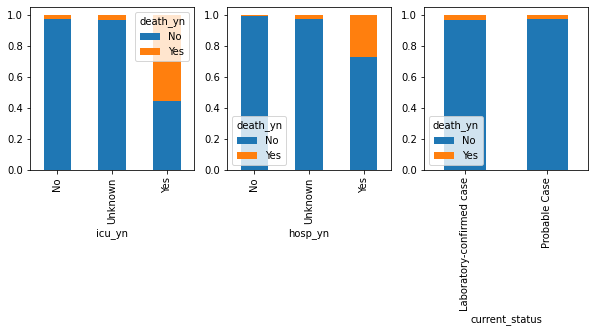

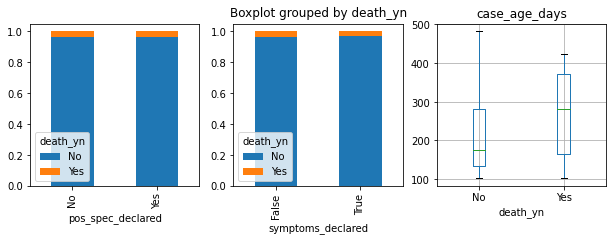

In [11]:
# Same as in assignment 1

fig, ax = plt.subplots(1, 3, figsize=(10,3))

plot_stacked_proportions("icu_yn", "death_yn", ax[0])
plot_stacked_proportions("hosp_yn", "death_yn", ax[1])
plot_stacked_proportions("current_status", "death_yn", ax[2])

# This time, also consider new features.

fig, ax = plt.subplots(1,3, figsize=(10,3))

plot_stacked_proportions("pos_spec_declared", "death_yn", ax[0])
plot_stacked_proportions("symptoms_declared", "death_yn", ax[1])

# Minor note: as per the suggestion the feedback from the previous assignment,
# I went back and was more careful with date formats in the data prep.
# It worked! The case_age is no longer has non-sensical negative values.

train_data.boxplot("case_age_days", by="death_yn", ax=ax[2])

Part 2: Traits of the patient.

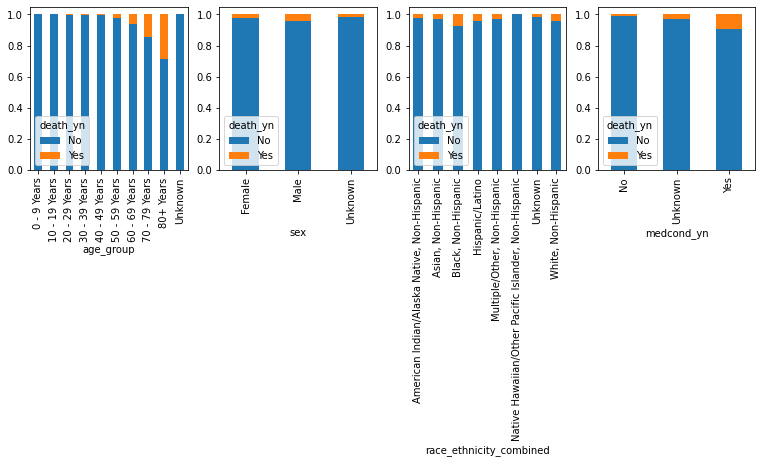

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(13,3))

plot_stacked_proportions("age_group", "death_yn", ax[0])
plot_stacked_proportions("sex", "death_yn", ax[1])
plot_stacked_proportions("race_ethnicity_combined", "death_yn", ax[2])
plot_stacked_proportions("medcond_yn", "death_yn", ax[3])

The question then is which of these feature to choose.

For now, to keep things simple, I'll choose the top five that seem most significant too me. (From a purely visual inspection of the graphs above)

  - icu_yn
  - age_group
  - hosp_yn
  - case_age_days
  - medcond_yn

In [15]:
iter1_features = [
    "icu_yn",
    "age_group",
    "hosp_yn",
    "case_age_days",
    "medcond_yn",
    "death_yn"
]

Before continuing to models and training, it's worth pausing and dealing with the fact that most of these ae categorical variables.

For now, I'm just going to use ordinal encoding for each. This could be very bad since it links missing values with yes, I think - for linear regression anyways. (Since no is 0, and missing and yes are positive)

The encodings will be normalized as well, for the sake of explaining weights later on.

The function below expects Yes/No/Unknown columns, and won't work for `age_group`. That feature we'll come to next. 

In [16]:
def encode_yn_ordinal(df, features):

    # It makes intuitive sense to put "Unknown" between
    # "Yes" and "No". This is actually very important, without it, 
    # the logistic model performs much much worse. I discovered this by teaking these
    # values on a whim at some point, and won't mention it after this.
    encoding = {
        "No": 0,
        "Unknown": 1,
        "Yes": 2
    }
    
    for feature in features:            

        new_series = df[feature].replace(encoding)
        new_series = new_series.astype(str).replace(encoding).astype(int)

        # Normalize. A simple min-max makes sense since there are only 3 classes.
        new_series = (new_series - new_series.min()) / (new_series.max() - new_series.min())

        df[feature] = new_series
        

# Quick test
data = a1_data[iter1_features].copy()
display(data.head(4))
encode_yn_ordinal(data, ["icu_yn", "hosp_yn", "medcond_yn", "death_yn"])
display(data.head(4))

,icu_yn,age_group,hosp_yn,case_age_days,medcond_yn,death_yn
0,Unknown,30 - 39 Years,No,246,Unknown,No
1,Unknown,10 - 19 Years,No,134,No,No
2,Unknown,10 - 19 Years,No,219,Unknown,No
3,Unknown,20 - 29 Years,Unknown,114,Unknown,No


,icu_yn,age_group,hosp_yn,case_age_days,medcond_yn,death_yn
0,0.5,30 - 39 Years,0.0,246,0.5,0.0
1,0.5,10 - 19 Years,0.0,134,0.0,0.0
2,0.5,10 - 19 Years,0.0,219,0.5,0.0
3,0.5,20 - 29 Years,0.5,114,0.5,0.0


The only categorical value that is *actually* ordinal here is `age_group`, so we need to take care with the ordering for that one. 
<br>
Also, "Unknown" in an ordinal age makes little sense, so I'll impute it with the mode for now. An indicator would be more suitable, but I'll leave that for part 5.

In [17]:
def encode_age(df):

    # Impute the mode for age_group Unknown.
    # This is a temporary measure! I'll introduce an indicator variable
    # in part 5, but I wanted to keep things as simple as possible for the
    # first iteration.
    mode = original.age_group.mode().values[0]
    df.age_group = original.age_group.replace("Unknown", mode)

    # I'm not sure this makes any difference, but reconstruct the category
    # with ordered = True (it is false by default).
    # Also make sure that the labels are in order (Though I think they are automatically sorted anyways)
    labels = sorted(df.age_group.unique())
    df.age_group = pd.Categorical(df.age_group, categories=labels, ordered=True)

    # Convert to numerical and normalize
    df.age_group = df.age_group.cat.codes
    age = df.age_group
    df.age_group = (age - age.min()) / (age.max() - age.min())


# Quick test.
original = a1_data[iter1_features].copy()
new_df = original.copy()
encode_age(new_df)
display(pd.DataFrame([
    original.head(10).age_group, 
    new_df.age_group.head(10)
], index=["label", "numerical"]))

,0,1,2,3,4,5,6,7,8,9
label,30 - 39 Years,10 - 19 Years,10 - 19 Years,20 - 29 Years,60 - 69 Years,20 - 29 Years,40 - 49 Years,60 - 69 Years,80+ Years,50 - 59 Years
numerical,0.375,0.125,0.125,0.25,0.75,0.25,0.5,0.75,1,0.625


Apply the various encodings on the data to create a normalized, numerical only dataset.

In [18]:
def normalize_case_age(df):
    
    feature = "case_age_days"
    m = df[feature].min()
    s = df[feature].std()
    df[feature] = (df[feature] - m) / (3 * s)
    


def iter1_encode(df):
    
    encode_yn_ordinal(df, ["icu_yn", "hosp_yn", "medcond_yn", "death_yn"])
    encode_age(df)
    normalize_case_age(df)

data = a1_data[iter1_features].copy()
iter1_encode(data)
data.head(4)

,icu_yn,age_group,hosp_yn,case_age_days,medcond_yn,death_yn
0,0.5,0.375,0.0,0.548309,0.5,0.0
1,0.5,0.125,0.0,0.121846,0.0,0.0
2,0.5,0.125,0.0,0.445501,0.5,0.0
3,0.5,0.250,0.5,0.045692,0.5,0.0


Perform the train-test split on the choice of features.

For the ease of use on the coming sections, I found it handy to store the various segments of data in a single container variable, since they are often passed around together in practice.

In [19]:
# The first attempt, with the default encodings.
iter1 = a1_data[iter1_features].copy()
iter1_encode(iter1)

Part 2: Linear Model
==

In [20]:
linear = sklearn.linear_model.LinearRegression

Fit a linear model using the numerical training sets.

In [21]:
def split(numerical_data):
    
    X = numerical_data.drop("death_yn", axis=1)
    y = numerical_data["death_yn"]
    
    return train_test_split(X, y, random_state=1, test_size=0.3)


def model_info(model_type, data):
    
    X_train, X_test, y_train, y_test = split(data)
    
    try:
        model = model_type(random_state=0)
    except:
        model = model_type()
    
    model.fit(X_train, y_train)
    
    model_info = pd.DataFrame(model.intercept_.reshape(1,1), columns=["intercept"])
    model_info[X_train.columns] = pd.DataFrame(model.coef_.reshape(1, model.coef_.size))
    
    return model_info

,intercept,icu_yn,age_group,hosp_yn,case_age_days,medcond_yn
0,-0.139605,0.047549,0.171153,0.1387,0.062157,0.023527


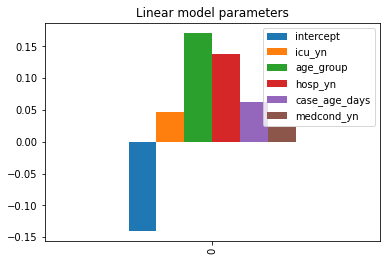

In [23]:
info = model_info(linear, iter1)
display(info)
info.plot(kind="bar", title="Linear model parameters");

The features are normalized, and I think the normalized distributions are okay, so the weights and intercept can be compared directly.

**intercept**
This is quite negative - even if all of the other features are maxed out, the model won't give a very high confidence of their being a death.

**icu, hsp, and med_cond**
I think icu may have been crippled by the encoding, and hosp and medcond may be affected as well. This is because icu has many many missing values most of whom could probably be imputed to no, and so any weight the model gives to icu being yes will bleed into icu being no.

**age_group**
This is the most important feature after icu and hsp, so it's no surprise to see it take the fore after the others are gone.

**case_age_days**
It's nice to see the custom feature contributing here. It's positive, which means recent cases have a higher chance of being a death according to the model. I admit that goes against my intuition.

Next, some predictions.

In [24]:
def apply_threshold(prediction, threshold, labels):

    prediction = (prediction > threshold).astype(int)
    prediction = [labels[i] for i in prediction]
    
    return prediction


def predict(model_type, data, threshold=None, resampler=None, 
            training_only=False):
    
    X_train, X_test, y_train, y_test = split(data)
    
    if resampler is not None:
        X_train, y_train = resampler(X_train, y_train)
    
    try:
        model = model_type(random_state=0)
    except:
        model = model_type()
    
    model.fit(X_train, y_train)

    if training_only:
        prediction = model.predict(X_train)
        actual = y_train
    else:
        prediction = model.predict(X_test)
        actual = y_test
        
    if threshold is not None:
        labels = np.sort(np.unique(y_train))
        prediction = apply_threshold(prediction, threshold, labels)
        
    return actual, pd.Series(prediction)

The first 10 predict false. This is not very surprising, giving the expected proportions.

In [25]:
# Predict for training data, not test data!
_, prediction = predict(linear, iter1, training_only=True)

prediction = pd.DataFrame(prediction, columns=["value"])
prediction["class"] = prediction.value > 0.5

display(prediction.head(10))

,value,class
0,-0.019096,False
1,-0.053088,False
2,-0.071549,False
3,0.017578,False
4,0.112489,False
5,0.010912,False
6,0.005507,False
7,0.040915,False
8,-0.075099,False
9,0.072397,False


Below are functions to help calculate the confusion matrix and positive rates, for a given threshold.

I recognize in hindsight that a lot of these little functions I have scattered about the place have premade and more complete implementations in sklearn or skplot. But on the upside, it was a reminder for me of what the various formulae actually mean.

In [26]:
def confusion(actual, prediction, labels=None):
    
    if labels is None: labels = np.sort(np.unique(actual))
    
    matrix = sklearn.metrics.confusion_matrix(actual, prediction, labels=labels)
    matrix = pd.DataFrame(matrix, index = ["Alive", "Dead"], columns = ["Alive", "Dead"])
    
    return matrix

The results with 0.5 as the threshold are terrible - 0 true positives.

This is exactly the same as the baseline prediction of always choosing false.

In [27]:
actual, prediction = predict(linear, iter1, training_only=True, threshold=0.5)

matrix = confusion(actual, prediction)
display(matrix)

,Alive,Dead
Alive,6263,0
Dead,240,0


With this in mind, metrics probably won't tell us much we don't already know, but I'll print them out anyways:

In [29]:
def class_metrics(*args, name=""):

    if type(args[0]) == pd.DataFrame:
        matrix = args[0]
    else:
        matrix = confusion(*args)
    
    matrix = matrix.values
    tn = matrix[0,0]
    fp = matrix[0,1]
    fn = matrix[1,0]
    tp = matrix[1,1]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    F1 = 2 * precision * recall / (precision + recall)
    
    result = pd.DataFrame([[accuracy, precision, recall, F1]]).T
    result.index = ["accuracy", "precision", "recall", "F1"]
    result.columns = [name]
    
    return result

In [30]:
actual, prediction = predict(linear, iter1, training_only=True, threshold=0.5)
class_metrics(actual, prediction)

C:\Users\Kieran\miniconda3\envs\titanic\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  from ipykernel import kernelapp as app


,
accuracy,0.963094
precision,NaN
recall,0.000000
F1,NaN


  - **Accuracy is high**. Well, given the overwhelming number of negatives in the dataset, always predicting negative yields a very high accuracy - we are almost always right.
  - **Precision is undefined**, since there are no positives in the predictions on which to base it
  - **Recall is 0**. We never predicted positive.
  - **F1 is undefined**, since it is based on precision and precision is undefined.
  
Technically, it is possible to calculate F1 by cancelling terms in the limit towards zero positives. The result is 0, which isn't anything new though.

Looking at the hold-out, the result is almost identical. The threshold is much too high.

This needs to be fixed before I can continue with this question.

In [31]:
actual, prediction = predict(linear, iter1, threshold=0.5)
class_metrics(actual, prediction)

C:\Users\Kieran\miniconda3\envs\titanic\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  from ipykernel import kernelapp as app


,
accuracy,0.965554
precision,NaN
recall,0.000000
F1,NaN


Aside: The Threshold
--

Okay. So I'm guessing the ordinal encoding was a bad idea, but it could also just be the overwhelming prevelance of "no death" in the data that is causing a low viable threshold. I'll leave the attempt to rememdy those two for part 5, and focus on the threshold itself for now.

First, plot the distribution of the predictions to get an idea for what is going on.

<AxesSubplot:ylabel='Frequency'>

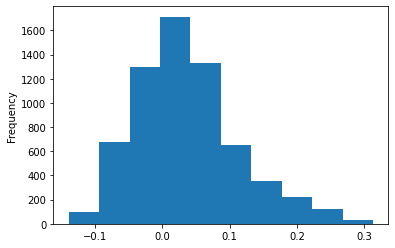

In [32]:
_, prediction = predict(linear, iter1, training_only=True)
prediction.plot(kind="hist")

Nothing much beyond 0.3. 

0.1 seems a decent candidate.

In [35]:
def display_metrics(*args, **kwargs):
    
    actual, prediction = predict(*args, **kwargs)

    matrix = confusion(actual, prediction)
    metrics = class_metrics(matrix)
    
    display(metrics)
    display(matrix)

Metrics for a threshold of 0.1

In [36]:
display_metrics(linear, iter1, threshold=0.1)

,
accuracy,0.868317
precision,0.194131
recall,0.895833
F1,0.319109


,Alive,Dead
Alive,2334,357
Dead,10,86


Not fantastic, given that a positive result is much more likely to be a false positive than not. Accuracy has decreased and precision is quite low. F1 is low.

Nonethless, most of the true negatives are being caught now, which is a huge improvement. 

The next cell defines functions for getting ROC information.

In [37]:
def roc(actual, prediction, thresholds, labels=None):
    
    if labels is None:
        labels = np.sort(np.unique(actual))
    
    items = list()
    for threshold in thresholds:
        
        p_current = apply_threshold(prediction, threshold, labels)

        matrix = confusion(actual, p_current)
        tp = matrix.values[1,1] / matrix.values[1,:].sum()
        fp = matrix.values[0,1] / matrix.values[0,:].sum()
        
        items.append([tp, fp])

    # each item in "rates" is a pair: a true positive, 
    # and a false positive.
    
    cols = ["true_p", "false_p"]
    roc = pd.DataFrame(items, index=thresholds, columns=cols)
    
    return roc


def plot_roc(roc_data, ax=None):

    if ax is None:
        ax = plt.gca()
    
    # The basic plot - false vs. true positives
    
    plt.title("ROC for linear model")
    plt.xlabel("False Positives")
    plt.ylabel("True Positives")
    ax.plot(roc_data.false_p, roc_data.true_p, "-")
        

def auroc(roc_data):
    
    x = roc_data.false_p
    y = roc_data.true_p
    
    # This interpolation & integration is giving me
    # a warning regarding error. I'm only looking for 
    # a rough guess for now though, so won't
    # try fix it.
    
    f = scipy.interpolate.interp1d(x, y)
    area = scipy.integrate.quad(f, 0, 1, limit=200)
    
    return area

The curve looks very very good for this model at first glance, though I suspect that that is just because the source data is mostly made of negatives, and so false positives are undervalued.

C:\Users\Kieran\miniconda3\envs\titanic\lib\site-packages\ipykernel_launcher.py:50: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


Area under ROC: 0.9376645104355669


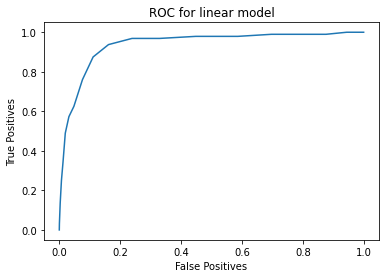

In [38]:
actual, prediction = predict(linear, iter1)

roc_data = roc(actual, prediction, np.linspace(-1, 1, 100))
plot_roc(roc_data)
print("Area under ROC:", auroc(roc_data)[0])

Some threshold values can be shown on the plot as well:

In [39]:
def show_thresholds(roc_data):

    distance = 0
    y1 = roc_data.true_p[roc_data.index[0]]

    for t in roc_data.index[1:]:

        # Don't display a threshold marker for every
        # point, since some are grouped together.
        # Wait until a certain y-distance has passed.
        
        x = roc_data.false_p[t]
        y2 = roc_data.true_p[t]

        distance += np.abs(y2-y1)
        y1 = y2
        
        if distance > 0.1:
            distance = 0
            plt.plot(x, y2, "o", color="#ff9900")
            plt.text(x + 0.04, y2, "t: %.2f" % t, color="#ff9900")

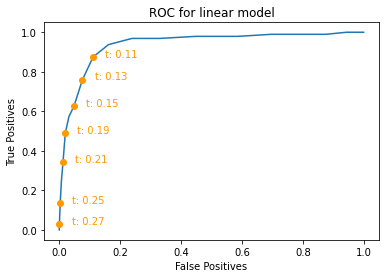

In [40]:
plot_roc(roc_data)
show_thresholds(roc_data)

From which I deduce that a threshold 0.1 is decent choice for now.

Still, we can do a linear search for the threshold that maximizes F1.

In [41]:
def find_threshold(actual, prediction, count=100, labels=None):

    thresholds = np.linspace(prediction.min(), prediction.max(), count)
    
    if labels is None:
        labels = np.sort(np.unique(actual))
    
    items = list()
    for threshold in thresholds:
        
        p_current = apply_threshold(prediction, threshold, labels)
        metrics = class_metrics(actual, p_current)
        score = metrics.T.F1
        items.append(metrics.T.F1)

    items = pd.Series(items, index=thresholds)
    return items.astype(float).idxmax()

In [42]:
actual, prediction = predict(linear, iter1)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    threshold = find_threshold(actual, prediction)

print("Chosen threshold: %.04f" % threshold)

print("Results:")
display_metrics(linear, iter1, threshold)

Chosen threshold: 0.1917
Results:


,
accuracy,0.963760
precision,0.475248
recall,0.500000
F1,0.487310


,Alive,Dead
Alive,2638,53
Dead,48,48


Back to Part 2: Linear Model
==

Recap: these are the metrics for the model when predicting training data.

In [43]:
display_metrics(linear, iter1, 0.19, training_only=True)

,
accuracy,0.955867
precision,0.423948
recall,0.545833
F1,0.477231


,Alive,Dead
Alive,6085,178
Dead,109,131


 - **accuracy is high** - Not as high as before, but nonetheless high. Expected due to the imbalance in the target feature.
 - **precision is below 50%** - A predicted positive is more likely to be a false positive than a true positive!
 - **recall is above 50%** - Half of the actual positives were detected.
 - **F1 is low** - Much better than before, but nonetheless somewhat low. 

Now, for the hold-out data:

In [44]:
display_metrics(linear, iter1, 0.19)

,
accuracy,0.963043
precision,0.466019
recall,0.500000
F1,0.482412


,Alive,Dead
Alive,2636,55
Dead,48,48


Almost identical before. In fact, it scores a little better. This is surprise to me - I'd have thought even a model not suffering from overfitting too much tends to perform better on the training data.

After seeing this trend a few times now in this notebook, I'm no longer so sure. I wonder is the model just simple enough (linear & 5 features) to avoid the problem within this dataset at least.

Finally, k-fold cross-validation. 

In [45]:
def kfold(k, model_type, data, threshold=None, resampler=None):
    
    X = data.drop("death_yn", axis=1).values
    y = data["death_yn"].values
    
    folder = sklearn.model_selection.KFold(k, shuffle=True, random_state=0)
    
    results = pd.Series([0.,0.,0.,0.], index=[
        "accuracy", "precision", "recall", "F1"
    ])
    
    labels = np.sort(np.unique(y))
        
    for train_index, test_index in folder.split(X, y):

        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        
        # I added this "resampler" parameter to help with part 5. 
        # The idea is to balance training data, but not testing data.
        if resampler is not None:
            X_train, y_train = resample(X_train, y_train)
        
        model = model_type()
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        prediction = pd.Series(prediction)
        
        # This is only relevant for the linear model, and should be None
        # for the other models.
        if threshold is not None:
            prediction = apply_threshold(prediction, threshold, labels)
        
        matrix = confusion(y_test, prediction, labels)
        metrics = class_metrics(matrix).T
        
        for item in results.index:
            if not np.isnan(metrics[item].iloc[0]):
                results[item] += metrics[item]
    
    results /= k
        
    return results

In [46]:
kfold(30, linear, iter1, threshold=0.19)

accuracy     0.958669
precision    0.440679
recall       0.503774
F1           0.458803
dtype: float64

For low k (k < 50), the metrics are similar to those from the hold-out data.

As k increases, the F1 and other values (except for accuracy) tend to decrease, which seemed counter-intuitive at first. Surely more training data is a good thing?

However, there are lots and lots of NaN warnings printed out (Which I have suppressed). I think what is happening is that as the test sample gets smaller, there are more and more samples with no predicted positives, and also more with no actual positives. This causes some of the metrics to go to NaN due to zero division errors, and contribute zero to the totals.

When I first ran this, accuracy tended to decrease too, but I was able to fix a similar error there - the confusion matrix was giving an error when there more no actual positives *and* no predicted positives.

I think this can be fixed by talling true and false positives instead of scores and calculating a shared score, but I have not chased this down.

In [47]:
with warnings.catch_warnings():
    
    # Comment out this to see a flood of warnings
    # relating to times when there were no predictions
    # and some metrics fall to NaN
    warnings.simplefilter("ignore")
    
    threshold = 0.19
    
    print("200 Iterations:")
    display(kfold(200, linear, iter1, threshold))
    
    print("400 Iterations:")
    display(kfold(400, linear, iter1, threshold))
    
    print("1000 Iterations:")
    display(kfold(1000, linear, iter1, threshold))

200 Iterations:


accuracy     0.958564
precision    0.390250
recall       0.431250
F1           0.380663
dtype: float64

400 Iterations:


accuracy     0.958587
precision    0.270375
recall       0.293958
F1           0.267163
dtype: float64

1000 Iterations:


accuracy     0.958544
precision    0.137500
recall       0.140333
F1           0.135414
dtype: float64

Part 3: Logistic Regression
==

In [48]:
logistic = sklearn.linear_model.LogisticRegression

Display fitted parameters.

,intercept,icu_yn,age_group,hosp_yn,case_age_days,medcond_yn
0,-10.555918,1.83713,6.126942,2.690406,1.205046,0.719347


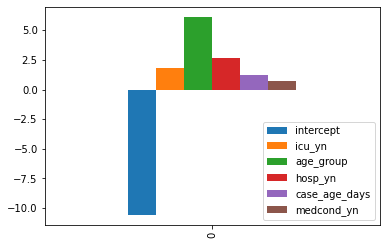

In [49]:
info = model_info(logistic, iter1)

display(info)
info.plot(kind="bar");

This graph of coefficients has similar properties to that for the linear model, which is no surprise. While the two models differ in the shape of the curve (or hyperplane) they apply to the data, they both follow a general principle of weighting significant features more, and, for our case, weighting risk factors against an initial intercept.

So age takes the lead as the most significant factor. I still think the y/n features are being undervalued here and will be more useful with indicator variables to support them. case_age_days is apprently not particularly significant in comparison to age.

In [50]:
_, prediction = predict(logistic, iter1, training_only=True)
prediction.head(10)

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
dtype: float64

In [51]:
display_metrics(logistic, iter1, training_only=True)

,
accuracy,0.966169
precision,0.608696
recall,0.233333
F1,0.337349


,Alive,Dead
Alive,6227,36
Dead,184,56


Low recall and high precision, combined to make an F1 that is lower than the ones I've come to expect from the linear model, which is interesting.

The accuracy is higher, since the precision of the positive when it makes a positive is higher.

In [52]:
display_metrics(logistic, iter1)

,
accuracy,0.967707
precision,0.588235
recall,0.208333
F1,0.307692


,Alive,Dead
Alive,2677,14
Dead,76,20


The metrics are much the same for training as for test data, as before. The test data scored a little better this time, but given the kfold results in the next cell that looks like noise to me rather than overfitting.

In [53]:
kfold(10, logistic, iter1)

accuracy     0.966631
precision    0.620144
recall       0.232206
F1           0.334285
dtype: float64

The model holds up well under kfolding - these metrics are roughly the same as the ones above.

Part 4: Random Forests
==

In [54]:
rforest = sklearn.ensemble.RandomForestClassifier

The first 10 predictions. There is one positive.

In [55]:
_, prediction = predict(rforest, iter1)
prediction.head(10)

0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
dtype: float64

The interpretation of Random Forests is a lot trickier than for the previous two models. They are often described as black boxes, and I can see why.

I started by printing out a few decision trees using the code below (replacing the "count" parameter with a higher number), but it was quickly evident that the trees were all wildly different. And even if they were not, the full tree is quite large.

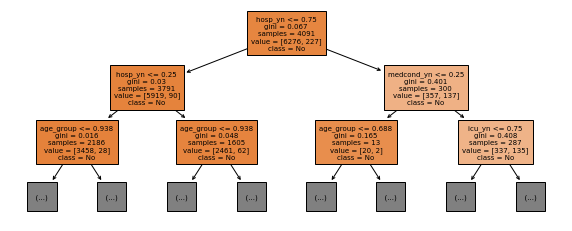

In [56]:
def show_trees(data, count):
    
    X_train, _, y_train, _ = split(data)
    
    model = rforest(random_state=0)
    model.fit(X_train, y_train)
    
    for i in range(min(count, len(model.estimators_))):
        tree = model.estimators_[i]
        plt.figure(figsize=(10,4))
        sklearn.tree.plot_tree(tree, ax=plt.gca(), max_depth=2, filled=True, fontsize=7,
                              class_names=["No", "Yes"], feature_names=X_train.columns);
        
show_trees(iter1, count=1)


There are the "feature importance" metrics in SKLearn, which may provide some insight.

The first of these considers the change in certainty (or impurity) as a particular record moves down the tree. It tallies the contribution of each feature towards becoming more certain of a class. For example, if after splitting on a certain feature we move to a node with a greater "yes" proportion, we can say that that feature contributed towards a "yes" prediction.

<AxesSubplot:>

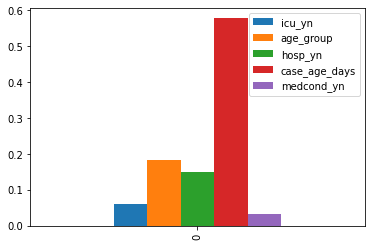

In [57]:
X_train, _, y_train, _ = split(iter1)

model = rforest(random_state=0)
model.fit(X_train, y_train)

results = model.feature_importances_ # This is an impurity based metric, according to the SKLearn docs.
frame = pd.DataFrame([results], columns=X_train.columns)
frame.plot(kind="bar")

The results show case_age_days as being the most important by far, which is extremely surprising. 

This starts to make more sense when the warning on the SKLearn documentation is taken into account, which says that the importance for a feature with many classes may be overestimated - case_age_days, being spread out over 400 days or so, has many many more classes than the other features.

Furthermore, this method of estimating importance is based on training data only and does not take the loss of prediction skill when test data is considered.

The doc can be found here: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

The documentation points towards a simpler metric that can be based on test data rather than training data, where high-cardinality features and overfitting do not cause problems. This is called "permutation importance".

It corrupts one column at a time, takes the resulting decrease in score to be a measure of the importance of that feature. i.e. the more important the column, the more skill we lose when it is taken away.

The docs for this one can be found here: https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

In [58]:
def permutation_importance(model_type, data, scoring=None, weights=None):

    X_train, X_test, y_train, y_test = split(data)
    
    try:
        model = model_type(random_state=0)
    except:
        model = model_type()
        
    model.fit(X_train, y_train)

    result = sklearn.inspection.permutation_importance(
        model, X_test, y_test, n_repeats=10, 
        random_state=0, scoring=scoring, sample_weight=weights)
    
    return pd.DataFrame([result["importances_mean"]], columns=X_train.columns)

<AxesSubplot:>

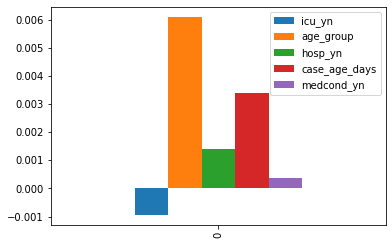

In [59]:
permutation_importance(rforest, iter1).plot(kind="bar")

This is more similar to the weights in the logistic/regression models, with the exception of icu. At first I was just confused by that in particular. (I cannot even blame the encoding this time, since a decision tree can choose ranges precisely and effectively re-encode things) 

However, it later occurred to me that the scoring metric was *accuracy* in this case. We know that because of the overwhleming imbalance in the target feature, any predictor that starts trying to predict with some recall tends to lose some accuracy. So icu being negative here is possibly a good thing.

That also means that removing the others each *decreased* accuracy, which is almost counter-intuitive now.

Before reading to much into this, though, and trying to explain it, I note that the magnitude of these changes is very, very small - less than 1%. All in all, this is deceptively nice looking graph, with simple intuitive origins, that is nonetheless hard to interpret.

A perhaps easier (if less directly intuitive) metric to deal with is F1.

<AxesSubplot:>

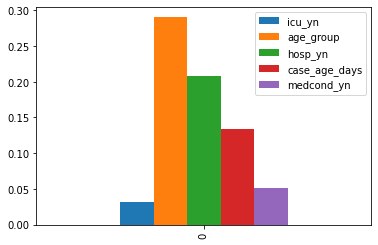

In [60]:
permutation_importance(rforest, iter1, "f1").plot(kind="bar")

Two things are immediately apparent - the proportionate change is score is much more significant now, and the magnitudes are as expected. 

It is still surprising to me that icu is so low. One thing to note is that the tree may spread out responsibility accross features acting as proxies to each other - it could be that between age_group and hosp_yn it has most of the information captured that icu_yn can give, or something like that.

We can also look at the accuracy each each class seperately.

<AxesSubplot:>

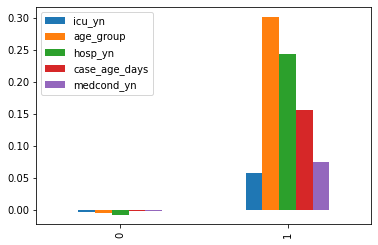

In [61]:
def feature_importances_by_class(data):

    _, _, _, y_test = split(data)
    
    # class 0
    weights = 1 - y_test
    result_0 = permutation_importance(rforest, data, "accuracy", weights)

    #class 1
    weights = y_test
    result_1 = permutation_importance(rforest, data, "accuracy", weights)
    result_1.index = [1]

    return pd.concat([result_0, result_1])

feature_importances_by_class(data).plot(kind="bar")

I like this graph in part because it highlights how small the effect on accuracy is in the positive case. The results for f1 scoring are reflected in the accuracy of the positive class.

The one issue I have with using permutation importance here is that it mixes scoring features with interpreting the model in a way that one cannot separate just looking at the graph. For all we know, there could be a feature that the tree uses all the time but that had little effect on the score. If the tree were to have that kind of strong hidden dependence on a feature, and the feature were to change dramatically, it could have unexpected effects.

That seems to be something the impurity based metric would be good at capturing. I gave a go at writing my own, based on test data rather than training data, in the hopes that it might avoid some of the pitfalls that are noted about the in-built one.

This attempt required a bit of rooting around the SKLearn docs. I found this link very very helpful:
https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py

It was an interesting rabbit hole, but the code is finicky and not well tested so I'm not at all confident that it is actually accurate!

In [62]:
def feature_importances(tree, data, prev_prediction=None):
    
    _, X_test, _, y_test = split(data)
    
    X = X_test
    y = y_test
    
    # We can precompute some values for each 
    # node in the tree to help performance a little.
    
    N = len(tree.value)
    decision = np.zeros(N) # If we stopped at this node, which would we choose?
    certainty = np.zeros(N) # How certain of the decision are we?
    features = [None]*N  # The relevant feature series from the training dataframe
    
    for node in range(N):
        
        a, b = tree.value[node][0]
        if a >= b:
            decision[node] = 0
        else:
            decision[node] = 1
        if a < b:
            a, b = b, a
        certainty[node] = a/(a+b)
        
        if tree.feature[node] >= 0:
            name = X.columns[tree.feature[node]]
            features[node] = X[name]
        
    # Now, follow the path of each record through the tree.
    # Record importances, but also record a prediction as a consistency
    # check, to help make sure we are correctly navigating the tree.
        
    importances = np.zeros(len(X.columns))
    importances_i = np.zeros(len(X.columns) + 1) # "+ 1" is to give the array a dummy slot used below.
    prediction = np.zeros(len(X))
    
    # I'm also interested in the breakdown of importance for yes vs no predictions
    
    importances_yes = np.zeros(len(X.columns))
    importances_no = np.zeros(len(X.columns))
    
    for record_i in range(len(X)):
        
        importances_i[:] = 0
        # This is the dummy slot in the array, since there is no initial
        # previous feature.
        previous_feature = len(importances_i) - 1 
        record = X.index[record_i]
        node = 0
        old_certainty = certainty[node]
        
        if prev_prediction is None:
            actual_value = y[y.index[record_i]]
        else:
            actual_value = prev_prediction[record_i]
        
        while True:
            
            # How has the previous branch affected certainty?
            
            new_certainty = certainty[node]
            delta = new_certainty - old_certainty
            
            if decision[node] != actual_value:
                # An increase in certainty in the wrong direction!
                delta *= -1
            
            importances_i[previous_feature] = delta
            
            # If we have reached a leaf, break
            
            if tree.children_left[node] == -1:
                break

            old_certainty = new_certainty
            previous_feature = tree.feature[node]
                
            # Figure out where to go next in the
            # tree.
                
            feature_value = features[node][record]
            threshold = tree.threshold[node]
            if feature_value <= threshold:
                node = tree.children_left[node]
            else:
                node = tree.children_right[node]
            
        prediction[record_i] = decision[node]
            
        # Normalize for the current run, so that longer paths
        # are not valued more than shorter paths
        importances_i /= np.abs(importances_i[0:-1]).sum()
        
        # Add to the overall tally. 
        # [0:-1] is because we do not include the dummy slot here.
        importances += importances_i[0:-1]
        if actual_value == 1:
            importances_yes += importances_i[0:-1]
        else:
            importances_no += importances_i[0:-1]
        
    # Normalize each so that they can be compared.
    importances /= np.abs(importances).sum()
    importances_yes /= np.abs(importances_yes).sum()
    importances_no /= np.abs(importances_no).sum()
            
    return prediction, importances, importances_yes, importances_no

Note - I'm printing out the predictions made by this function as well as the importances as a consistency check. They match below, but I've also seen them differ by a small amount occasionally - I think there might be some edge cases or minor details regarding comparison with which I have not matched the original SKLearn version.

,Actual,Test,Test II
0,2694,2694,2694
1,93,93,93


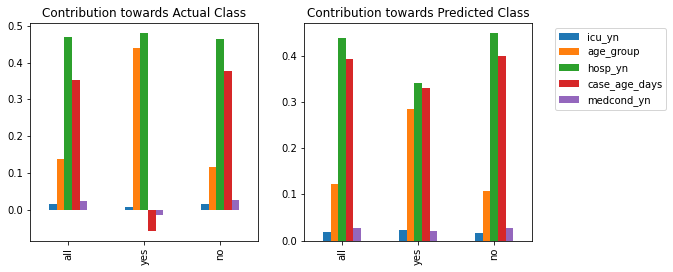

In [63]:
data = iter1
X_train, X_test, y_train, _ = split(data)

model = rforest(random_state=0)
model.fit(X_train, y_train)
dtree = model.estimators_[0]

# Actual prediction, according the SKLearn

actual_prediction = dtree.predict(X_test)

# Importances during our own navigation, comparing changes in
# certainty to the actual value.

test_prediction, i, i_yes, i_no = feature_importances(dtree.tree_, data)

# Importances during our own navigation, comparing changes in
# certainty to the final predicted value.

prev_prediction = test_prediction
test_prediction_2, i2, i2_yes, i2_no = feature_importances(dtree.tree_, data, prediction)

# Display

consistency = pd.DataFrame([
    pd.Series(actual_prediction).value_counts(), 
    pd.Series(test_prediction).value_counts(), 
    pd.Series(test_prediction_2).value_counts()
], index=["Actual", "Test", "Test II"], columns=[0, 1])
display(consistency.T)

_, ax = plt.subplots(1, 2, figsize=(9,4))

frame = pd.DataFrame([i, i_yes, i_no],
    columns=X_test.columns, 
    index=["all", "yes", "no"])
frame.plot(kind="bar", ax=ax[0], legend=False,
           title="Contribution towards Actual Class");

frame = pd.DataFrame([i2, i2_yes, i2_no],
    columns=X_test.columns, 
    index=["all", "yes", "no"])
frame.plot(kind="bar", ax=ax[1],
          title="Contribution towards Predicted Class");
plt.legend(loc=(1.1,0.6))

The above graphs are just for one tree. It's actually quite fun to cycle through the trees - while there are general trends, some are so different from the others.

Next, average the result across all trees. This cell takes a few minutes to run!

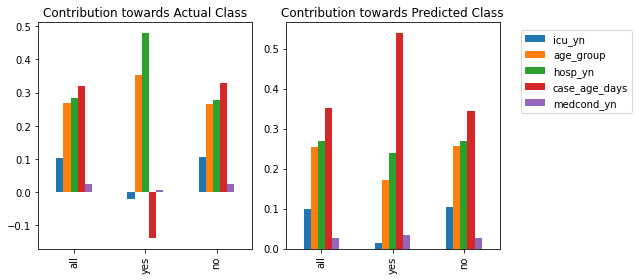

In [54]:
def feature_importances_combined(forest, count, data, X_test):
    
    # 2 types of importances, 3 classes, N columns
    
    N = len(X_test.columns)
    totals = np.zeros([2, 3, N])
    
    # Tally individual tree scores for each
    
    for index in range(count):
        dtree = forest.estimators_[index]
        prev_prediction, i11, i12, i13 = feature_importances(dtree.tree_, data)
        _, i21, i22, i23 = feature_importances(dtree.tree_, data, prev_prediction)
        totals += [[i11, i12, i13], [i21, i22, i23]]
    
    # Normalize each result
    
    for i in range(2):
        for j in range(3):
            totals[i, j, :] /= np.abs(totals[i, j, :]).sum()
    
    # Display
    
    _, ax = plt.subplots(1, 2, figsize=(9,4))
    
    frame = pd.DataFrame(totals[0], 
        columns=X_test.columns, 
        index=["all", "yes", "no"])
    frame.plot(kind="bar", ax=ax[0], legend=False,
               title="Contribution towards Actual Class")
    
    frame = pd.DataFrame(totals[1], 
        columns=X_test.columns, 
        index=["all", "yes", "no"])
    frame.plot(kind="bar", ax=ax[1], 
               title="Contribution towards Predicted Class")
    
    plt.legend(loc=(1.1,0.6))


X_train, X_test, y_train, _ = split(data)    
model = rforest(random_state=0)
model.fit(X_train, y_train)

feature_importances_combined(model, len(model.estimators_), iter1, X_test)

Predicted vs. Actual is interesting here, especially in the yes-only case. Case age featured greatly in the prediction, but the sum total was actually to push the tree away from the correct answer. This could be overfitting at play. I'm straying into discussion about scores again though, the point is that case_age_days features a lot in the decision tree.

This also echoes the the result from the original in-built method. I read the warning in the docs as a being about a flaw in method, but I think that was from the perspective of scoring features - it's actually quite relevant when just thinking about how the model is doing things, rather than how well it is doing things.

The same applies to icu and medcond on a lesser scale.

In [64]:
display_metrics(rforest, iter1, training_only=True)

,
accuracy,0.993695
precision,0.954338
recall,0.870833
F1,0.910675


,Alive,Dead
Alive,6253,10
Dead,31,209


Well, the F1 score for the training data is extremely high, vastly outperforming the other two models. Overfitting seems likely, so I'll move straight on to the test data.

In [65]:
display_metrics(rforest, iter1)

,
accuracy,0.962325
precision,0.447059
recall,0.395833
F1,0.419890


,Alive,Dead
Alive,2644,47
Dead,58,38


And indeed, the model scores much less well with the test data. It has fairly balanced precision and recall. The score is lower than it is for the fully adjusted linear model, but it is higher than the out-of-the-box logistic model.

It makes sense that the random forest tends to overfit - the number of free parameters is much greater, so it can mold itself to the data really, really well. In fact, it can capture the sample data so well that the differences between the sample and test data become very significant.

Now, for kfolding:

In [66]:
kfold(10, rforest, iter1)

accuracy     0.957912
precision    0.403323
recall       0.339127
F1           0.365461
dtype: float64

The F1 score is lower again - either we got lucky with the train-test split, or the model is overfitting even more having 90% of the data available to it. It might be interesting to revisit this with a random forest that has fewer nodes on each tree.

Part 5: Improvements
==

In terms of raw accuracy on the test data, the logistic model scores highest, with a score of 96%. The others are not far behind, both around 95%. (The linear one does need the threshold carefully adjusted for this, though)

This is around the same as a model that predicts all negatives, since only about 3.6% of the data is positive, which means we'd expect the baseline all-no classifier to get about 96% accuracy.

In [67]:
# How imbalanced was the original dataset?
(a1_data.death_yn == "Yes").sum() / len(a1_data)

0.036167922497308935

Of course, it is this imbalance in the data that makes accuracy a fairly terrible measure to begin with, unless we weight it in some way or rebalance the data.

Taking F1 as our measure, the ranking is the exact opposite: the linear performs best at around 0.46, the random forest is about 0.36 when kfolding (0.41 for the train-test split) and the logistic model is at 0.30.

To summarize the thoughts about performance scattered above:

**Linear Regression**
   - Requires careful threshold tuning.
   - Once tuned, it performs relatively well - it manages a precision and recall of almost 0.5. 
   - Performs just as well in kfold as it does on training data, more or less. 
   - age_group and hosp_yn are by far the most significant weights. 
   - It seems to be unable to leverage icu - perhaps because of the encoding?
   

**Logistic Regression**
   - Similar weighting to the linear mode.
   - Performs much worse. This might be because I do not know how to tune it, though.
   - It's possible rebalancing the data could achieve the same affect as tuning.
   - Again, re-encoding icu might help.
   - Again, performs as well in kfold as in training data - no overfitting.
   

**Random Forest**
   - Much harder to interpret, but seems to have similar priorities regarding features to the other two.
   - Major difference with case_age_days - it seems to rely on it too much and overfit.
   - Performs vastly better on training data - overfitting is an issue.
   - Nonetheless, performs relatively well in kfold compared to the logistic regression.

The linear model is best for me.

Ideas for improvements:
   - Re-balance data.
   - Re-encode with dummy variables.
   - Add gender.
   - Add indicator for age missing.
   - Combine models, with weighting.
  
**Note 1:** I was originally intending to include the threshold tuning for the linear model in part 5 instead of part 2. I know part 2 specifically asks for a threshold of 0.5, sorry! But the model was completely crippled without it. I'm mentioning this here beause if it oversteps the bounds of part 2 it could be considered a part of part 5 instead.

**Note 2:** Imputing age was always a temporary measure to make interpreting the prototype model easy. An indicator variable seems like a natural precaution to add there.

A function for summarizing the linear model with a given dataset.

In [68]:
def display_linear(data, resampler=None, params=False, title="Linear"):
    
    actual, prediction = predict(linear, data, resampler=resampler)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        t = find_threshold(actual, prediction, count=100)
    
    kwargs = dict(
        threshold = t,
        resampler = resampler
    )
    
    actual, prediction = predict(linear, data, training_only=True, **kwargs)
    training_metrics = class_metrics(actual, prediction)
    
    actual, prediction = predict(linear, data, **kwargs)
    test_metrics = class_metrics(actual, prediction)
    
    kfold_metrics = kfold(10, linear, data, **kwargs)
    
    metrics = pd.concat([training_metrics, test_metrics, kfold_metrics], axis=1)
    
    metrics.columns = pd.MultiIndex.from_product([
        [title], ["Training", "Test", "KFold"]
    ])
    
    if params:
        linear_info = model_info(linear, data)
        linear_info.plot(kind="bar")

    display(metrics)

Sampling
--

First, regarding data balancing. There are two main ways of doing this - dropping records with the majority class, or duplicating records with the minority class. 

Functions for over and under sampling. I imagine there must be neater way to do this, but it will do.
<br>(Retrospective edit: https://pypi.org/project/imbalanced-learn/ is an example package that would have saved me some trouble here)

In [69]:
def resample(train, test, method="under"):
    
    random = np.random.RandomState(42)
    
    if method == "under":
        replace = False
        target_mask = test
        
    elif method == "over":
        replace = True
        target_mask = 1 - test
        
    else:
        raise ValueError("Method must be one of 'under' or 'over'.")
        
    total_count = len(train)
    target_count = int(target_mask.sum())
    p = 1 - target_mask
    p /= p.sum()
    
    choice = random.choice(range(total_count), target_count, 
                            replace=replace, p=p)
    
    choice_mask = np.zeros(len(test))
    for item in choice:
        choice_mask[item] = 1
    
    records = target_mask.astype(bool) | choice_mask.astype(bool)
  
    try:
        records = records.index[records]
        train, test = train.loc[records], test.loc[records]
    except:
        train, test = train[records], test[records]
    
    return train, test

Experiment with the undersampling and oversampling functions. This cell takes a minute to run.

In [70]:
def undersample(train, test): 
    return resample(train, test, "under")

def oversample(train, test): 
    return resample(train, test, "over")

display_linear(iter1, title="unchanged")

for method in [undersample, oversample]:
    display_linear(iter1, method, title=method.__name__)

unchanged                    
           Training      Test     KFold
accuracy   0.955405  0.963760  0.959419
precision  0.416667  0.475248  0.450354
recall     0.520833  0.500000  0.496500
F1         0.462963  0.487310  0.469892

undersample                    
             Training      Test     KFold
accuracy     0.829167  0.958378  0.949085
precision    0.959302  0.428571  0.384612
recall       0.687500  0.625000  0.655769
F1           0.800971  0.508475  0.483408

oversample                    
            Training      Test     KFold
accuracy    0.955405  0.963760  0.542196
precision   0.416667  0.475248  0.072535
recall      0.520833  0.500000  0.989675
F1          0.462963  0.487310  0.135033

Undersampling gave a small improvement in F1. Oversampling was extremely deterimental.

Undersampling also led to a big difference between training and test data, which does make some sense - there is so much less training data and the linear model is a lot less general than it was before. This has not negatively impacted its performance though.

I really don't know why oversampling is that deterimental, which is problematic since it means I'm not confident in the undersampling either - they are similar in certain ways and I don't see where the difference is.

If I were to come back and spend some more time on the assignment, incidentally, this is one of the parts I would like to explore further. This and tuning the random forest / logistic models

Adding or Removing Features
--

First, regarding gender.

In [71]:
data = a1_data[[
    "icu_yn", "age_group", "hosp_yn", "medcond_yn", "case_age_days",
    "sex",
    "death_yn"
]].copy()

# Male seems to be a risk factor, hence "Yes"
data = data.replace("Male", "Yes").replace("Female", "No")
encode_yn_ordinal(data, ["icu_yn", "hosp_yn","medcond_yn", "death_yn", "sex"])
encode_age(data)
normalize_case_age(data)

display_linear(iter1, title="unchanged")
display_linear(data, title="with gender")

unchanged                    
           Training      Test     KFold
accuracy   0.955405  0.963760  0.959419
precision  0.416667  0.475248  0.450354
recall     0.520833  0.500000  0.496500
F1         0.462963  0.487310  0.469892

with gender                    
             Training      Test     KFold
accuracy     0.953406  0.962325  0.956835
precision    0.408163  0.461538  0.430665
recall       0.583333  0.562500  0.548982
F1           0.480274  0.507042  0.480523

Well, adding gender leads to a small increase in F1. This is nice. The fact that it is just a small change isn't surprising given that the plots in part 1 only showed a slight relationship.

A second change I wished to experiment with is removing case_age_days. I do not expect this to improve things at all, but I'm not sure how much it will decrease performance either. Starting out, I had high hopes for it, but recently I'm become concerned that it might become a source of overfitting, especially if the training data and new data are far apart in time.

In [72]:
data = a1_data[[
    "icu_yn", "age_group", "hosp_yn", "medcond_yn",
    "death_yn"
]].copy()

encode_yn_ordinal(data, ["icu_yn", "hosp_yn", "medcond_yn", "death_yn"])
encode_age(data)

display_linear(data)

Linear                    
           Training      Test     KFold
accuracy   0.939413  0.942591  0.940366
precision  0.350775  0.333333  0.347865
recall     0.754167  0.666667  0.729762
F1         0.478836  0.444444  0.470156

It actually increased F1 in the kfold case by a tiny amount...

I'll probably remove this in the final model.

Dummy Variables
--

A new encoding function for age, taking missing values into account.

In [73]:
def encode_age_with_indicator(df):

    # Replace "Unknown" with zero and add a "missing indicator"
    df["age_group_missing"] = (original.age_group == "Unknown").astype(int)
    df.age_group = original.age_group.replace("Unknown", "0")

    # The rest is the same as before.
    
    labels = sorted(df.age_group.unique())
    df.age_group = pd.Categorical(df.age_group, categories=labels, ordered=True)

    df.age_group = df.age_group.cat.codes
    age = df.age_group
    df.age_group = (age - age.min()) / (age.max() - age.min())

    
# Quick test
data = a1_data.copy()
encode_age_with_indicator(data)
columns = ["age_group", "age_group_missing"]
display(data[columns].head(3))
display(data[data.age_group_missing == True][columns].head(3))

,age_group,age_group_missing
0,0.444444,0
1,0.222222,0
2,0.222222,0


,age_group,age_group_missing
1130,0.0,1
1621,0.0,1
1875,0.0,1


Linear                    
           Training      Test     KFold
accuracy   0.955405  0.963760  0.959419
precision  0.416667  0.475248  0.450354
recall     0.520833  0.500000  0.496500
F1         0.462963  0.487310  0.469892

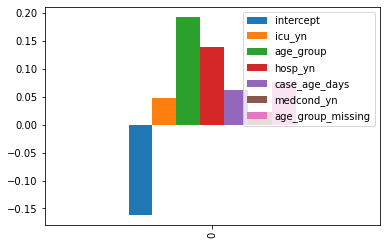

In [74]:
data = a1_data[iter1_features].copy()

encode_age_with_indicator(data)
encode_yn_ordinal(data, ["icu_yn", "hosp_yn", "death_yn", "medcond_yn"])
normalize_case_age(data)

display_linear(data, params=True)

The difference to F1 is negligible. That being said, I'll keep the change anyways, since this seems like a better way to handle the case where we have some input with a lot of missing ages.

The model makes use of the indicator in a way that seems like it might be equivalent to my originally imputing the mode, though I've not tried to test that with any rigour.

Onto dummy variables for the yes/no features. 

In [75]:
def encode_yn_dummy(df, features):
    
    new_df = df.copy()
    
    for column_name in features:
    
        dummies = pd.get_dummies(df[column_name], drop_first=True)
        dummies.columns = column_name + "_" + dummies.columns.astype(str)

        new_df = new_df.drop(column_name, axis=1)
        new_df = pd.concat([new_df, dummies], axis=1)
    
    return new_df      

# Quick test
data = a1_data[iter1_features]
display(data.head(4))
display(encode_yn_dummy(data, ["hosp_yn", "medcond_yn", "icu_yn"]).head(4))

,icu_yn,age_group,hosp_yn,case_age_days,medcond_yn,death_yn
0,Unknown,30 - 39 Years,No,246,Unknown,No
1,Unknown,10 - 19 Years,No,134,No,No
2,Unknown,10 - 19 Years,No,219,Unknown,No
3,Unknown,20 - 29 Years,Unknown,114,Unknown,No


,age_group,case_age_days,death_yn,hosp_yn_Unknown,hosp_yn_Yes,medcond_yn_Unknown,medcond_yn_Yes,icu_yn_Unknown,icu_yn_Yes
0,30 - 39 Years,246,No,0,0,1,0,1,0
1,10 - 19 Years,134,No,0,0,0,0,1,0
2,10 - 19 Years,219,No,0,0,1,0,1,0
3,20 - 29 Years,114,No,1,0,1,0,1,0


unchanged                    
           Training      Test     KFold
accuracy   0.955405  0.963760  0.959419
precision  0.416667  0.475248  0.450354
recall     0.520833  0.500000  0.496500
F1         0.462963  0.487310  0.469892

with dummies                    
              Training      Test     KFold
accuracy      0.956789  0.961249  0.958881
precision     0.429066  0.440000  0.438834
recall        0.516667  0.458333  0.450139
F1            0.468809  0.448980  0.441133

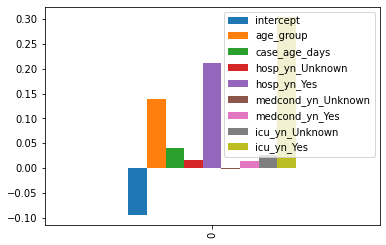

In [76]:
data = a1_data[iter1_features].copy()

encode_age(data)
data = encode_yn_dummy(data, ["hosp_yn", "medcond_yn", "icu_yn"])
encode_yn_ordinal(data, ["death_yn"])
normalize_case_age(data)

display_linear(iter1, title="unchanged")
display_linear(data, params=True, title="with dummies")

Well, ICU came to the fore in the linear model! 

Still though, this change has resulted in a significant decrease in score. The dummy variables here as essentially just indicator vars, I thought this might help the linear model leverage features with many missing variables. And while the linear model is very different as a result, this seems to have made things worse, not better.

I'll try encoding icu only with dummies next, since that feature was the main focus of the excercise to begin with.

unchanged                    
           Training      Test     KFold
accuracy   0.955405  0.963760  0.959419
precision  0.416667  0.475248  0.450354
recall     0.520833  0.500000  0.496500
F1         0.462963  0.487310  0.469892

with icu as dummy                    
                   Training      Test     KFold
accuracy           0.951561  0.958737  0.953929
precision          0.395543  0.424000  0.404982
recall             0.591667  0.552083  0.551848
F1                 0.474124  0.479638  0.463878

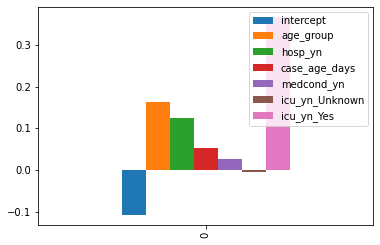

In [77]:
data = a1_data[iter1_features].copy()

encode_age(data)
encode_yn_ordinal(data, ["hosp_yn", "medcond_yn", "death_yn"])
data = encode_yn_dummy(data, ["icu_yn"])
normalize_case_age(data)

display_linear(iter1, title="unchanged")
display_linear(data, title="with icu as dummy", params=True)

Giving icu the indicator certainly has changed the model significantly, but the resulting change in F1 is very very small.

I'm not sure what to make of this. Perhaps hosp_yn and age_group are effectively proxies for icu already? 

Combining Models
--

The last idea for improvement I'll take a look at in this notebook is combining models.

My ensemble strategy is very simple - predict with which individually, make a weighted sum of the individual predictions, and then use a constant threshold to determine the result for each record.

The weights mean we can trust one model over another. The threshold determines how many models need to make a predicted positive before positive is taken as the result.

In [78]:
def ensemble_predict(data, weights=None, threshold=0):
    
    if weights is None:
        weights = [1, 1, 1]
        
    weights = np.array(weights, float)
    weights /= weights.sum()
    
    # We need to determine the threshold for the linear model first.
    actual, prediction = predict(linear, data)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        linear_threshold = find_threshold(actual, prediction)
    
    # Now, predict with each model.
    _, lin = predict(linear, data, threshold=linear_threshold)
    _, log = predict(logistic, data)
    _, forest = predict(rforest, data)
    
    a, b, c = weights
    combined = a * lin + b * log + c * forest
    combined = (combined > threshold).astype(int)

    metrics = pd.concat([
        class_metrics(actual, lin),
        class_metrics(actual, log),
        class_metrics(actual, forest),
        class_metrics(actual, combined)
    ], axis=1)
    metrics.columns=["Linear", "Logistic", "Random Forest", "Combined"]
    
    return actual, combined, metrics

Combining the evenly weighted models meant an increase in F1, which initially was wonderfully counter-intuitive to me. It is welcome. The F1 score is only marginally higher than the highest individual model, but nonetheless it is the highest achieved so far.

In [79]:
_, _, metrics = ensemble_predict(iter1, threshold=0)
display(metrics)

,Linear,Logistic,Random Forest,Combined
accuracy,0.963760,0.967707,0.962325,0.959096
precision,0.475248,0.588235,0.447059,0.431818
recall,0.500000,0.208333,0.395833,0.593750
F1,0.487310,0.307692,0.419890,0.500000


The above is with a threshold of 0 - if any model spots a possible positive, the prediction is positive.

Increasing the threshold so that more than one positive prediction is needed significantly decreases recall and decreases F1.

In [80]:
_, _, metrics = ensemble_predict(iter1, threshold=0.34)
display(metrics)

,Linear,Logistic,Random Forest,Combined
accuracy,0.963760,0.967707,0.962325,0.967348
precision,0.475248,0.588235,0.447059,0.540984
recall,0.500000,0.208333,0.395833,0.343750
F1,0.487310,0.307692,0.419890,0.420382


I take this to mean that different models identify different positive cases, and that getting them to "vote" on the result will often lead to a spotted case that was not spotted by the others to go unpredicted. 

Because we're maximizing recall between the different models, I doubt weights will be useful.

One thing I wanted to try though is to trust the linear model over the other two:

In [81]:
_, _, metrics = ensemble_predict(iter1, weights=[0.5, 0.25, 0.25], threshold=0.3)
display(metrics)

,Linear,Logistic,Random Forest,Combined
accuracy,0.963760,0.967707,0.962325,0.963760
precision,0.475248,0.588235,0.447059,0.475248
recall,0.500000,0.208333,0.395833,0.500000
F1,0.487310,0.307692,0.419890,0.487310


This is quite useless - in order to "outvote" the linear model, both the logistic and random forest models would have to agree on a case the linear model missed. Apparently this never happens, which is not surprising.

All in all, there is a noticable improvement with the ensemble, but it is not at all worth the extra effort involved in this case in my opinion. If I had better tuned the other models and the scores were more balanced, this might have been more worthwhile.

The Final Model
--

To summarize the findings of the previous section:

  - undersampling helped slighly.
  - oversampling hindered.
  - adding gender helped.
  - removing case_age made no difference.
  - dummy variable encodings for all binary variables had a negative impact.
  - dummy variable encodings for icu had a neutral impact, but changed things internally.
  - adding an indicator for age changed little.
  - combining models lead to a small increase in score.

For the final model, I'll use the linear model only and leave it mostly unchanged from before. I don't think the ensemble is worth the loss in simplicity and interpretability. I will add in gender and keep and indicator for age, and omit case_age. I won't undersample, since that adds to the complexity as well and didn't make much difference.

This cell is also a bit of a recap of the entire notebook - since this is the "take-away" model of this project, I did not want it to depend on any of the utilities I had previously defined for myself.

In [82]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
from datetime import datetime, timedelta


def clean_data(path, date_format):

    data = pd.read_csv(path)

    # There is depracted column that is removed straight away.
    data = data.drop(["cdc_report_dt"], axis=1)

    # Parse dates manually
    for column in data.columns[0:3]:
        data[column] = pd.to_datetime(data[column], format=date_format)

    # Drop all duplicates. (about 7% of the data)
    data = data.drop_duplicates(keep="first")

    # Case age.
    data["case_age"] = datetime.now() - data["cdc_case_earliest_dt"]
    
    # Cleaning
    data = data.drop("pos_spec_dt", axis=1)
    data = data.drop("onset_dt", axis=1)
    data = data.replace("Missing", "Unknown")
    data = data.replace("OTH", "Unknown")
    data = data.replace("Other", "Unknown")
    
    # Categorical columns
    cat_features = [
        "current_status",
        "sex",
        "age_group",
        "race_ethnicity_combined",
        "hosp_yn",
        "icu_yn",
        "death_yn",
        "medcond_yn"
    ]
    for feature in cat_features:
        data[feature] = data[feature].astype("category")

    # Case age days
    data["case_age"] = pd.to_timedelta(data["case_age"])
    data["case_age_days"] = data["case_age"].map(lambda td: td.days)
    
    return data


def prepare_data(data):
    
    data = data[[
        "icu_yn", 
        "age_group", 
        "hosp_yn", 
        "medcond_yn", 
        "sex",
        "death_yn" 
    ]].copy()


    # Add missing indicator for age
    data["age_group_missing"] = (data.age_group == "Unknown").astype(int)

    # Ordinal encoding for age, starting with Unknown.
    data.age_group = data.age_group.replace("Unknown", "0")
    labels = sorted(data.age_group.astype(str).unique())
    data.age_group = pd.Categorical(data.age_group, categories=labels, ordered=True)
    data.age_group = data.age_group.cat.codes

    # Ordinal encoding for the remaining yes/no variables
    data = data.replace("Male", "Yes").replace("Female", "No")
    data = data.replace("Yes", 2).replace("No", 0).replace("Unknown", 1)

    # Normalize the rest using min-max
    for feature in set(data.columns) - set(["case_age_days"]):
        data[feature] = data[feature].astype(int)
        a, b = data[feature].min(), data[feature].max()
        data[feature] = (data[feature] - a) / (b - a)
        
    return data


def get_metrics(actual, prediction, frame=False, name=None):

    matrix = confusion_matrix(actual, prediction, labels=[0,1])
    
    tn = matrix[0,0]
    fp = matrix[0,1]
    fn = matrix[1,0]
    tp = matrix[1,1]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    F1 = 2 * precision * recall / (precision + recall)
    
    if not frame:
        return accuracy, precision, recall, F1
    
    frame = pd.DataFrame([[accuracy, precision, recall, F1]]).T
    frame.index = ["accuracy", "precision", "recall", "F1"]
    frame.columns = [name]
    
    return frame    


def find_threshold(actual, prediction, count=100):

    thresholds = np.linspace(prediction.min(), prediction.max(), count)
    
    items = list()
    for threshold in thresholds:
        p_current = (prediction > threshold).astype(int)
        _, _, _, F1 = get_metrics(actual, p_current)
        items.append(F1)

    items = pd.Series(items, index=thresholds)
    return items.astype(float).idxmax()


def prepare_model(training_data):

    # First, to determine the threshold
    
    X = training_data.drop("death_yn", axis=1)
    y = training_data["death_yn"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        threshold = find_threshold(y_test, prediction)

    # Make a prediction within the training data
    # for the sake of printing estimated metrics
            
    prediction = model.predict(X_test)
    prediction = (prediction > threshold).astype(int)
    
    metrics = get_metrics(y_test, prediction, frame=True, name="Training Hold-out")
    
    # Train on the full training data set
    
    model.fit(X, y)
    
    # Create the function for making 
    # predictions with test data.
    
    def predict(test_data):
                    
        X = test_data.drop("death_yn", axis=1)
        y = test_data["death_yn"]
            
        prediction = model.predict(X)
        prediction = (prediction > threshold).astype(int)
        
        return prediction
    
    return predict, metrics

New Data
--

In [83]:
training_data = clean_data("covid19-cdc-16498802.csv", "%d/%m/%Y")
new_data = clean_data("24032021-covid19-cdc-deathyn-recent-10k.csv", "%Y/%m/%d")

training_data = prepare_data(training_data)
new_data = prepare_data(new_data)

predictor, training_metrics = prepare_model(training_data)
display(training_metrics)

prediction = predictor(new_data)
true_metrics = get_metrics(new_data.death_yn, prediction, frame=True, name="Actual")
display(true_metrics)

,Training Hold-out
accuracy,0.959813
precision,0.520325
recall,0.547009
F1,0.533333


,Actual
accuracy,0.966831
precision,0.229730
recall,0.439655
F1,0.301775


The first table shows the metrics for a train-test split with hold-out data, only considering the old dataset. (Same as before)

The second table shows the metrics for the same model, fitted on all of the old data, tested against all of the new data.

I didn't expect the hold-out F1 to go above 0.5, there is probably some luck involved there. I didn't expect the F1 for the new data to fall all the way to 0.3 either. The linear model seemed to be doing so well in kfold tests that I thought it might be very resistant to overfitting. I guess I'm underestimating the different between the two datasets - are they greatly separated in time?

One interesting difference is that the recall fell much less than the precision. If I were to briefly guess that that the new dataset is from a significantly later date, I might guess that a smaller proportion of people were dying of COVID at that later date. But that is a wild guess, there are so many possible reasons for variance between the two datasets.

That's it for this project! My main conclusion is that a linear model with few features can be as good as or better a more complicated model with more features - obvious as it might seem, this is the first time I've seen it in practice. 

That being said, I wonder if my initial choice of simple feature set gave the random forest some trouble, and if it would have performed better given all the features that were not date related. Also, I had a degree of control over tuning the linear model I did not have with the others - the threshold. I'd be interested in finding out how to tune the others at some point. Finally, I'm still confused by the effect over/under sampling had, and intend to explore that more someday.